In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.interpolate import RegularGridInterpolator

Nt, Nf = 10, 12

def cnm(f):
    n_vals = jnp.arange(Nt)
    m_vals = jnp.arange(Nf)

    M = n_vals[:, jnp.newaxis] + m_vals[jnp.newaxis, :]

    return f * M

num_f_points = 20
f_grid = jnp.linspace(0.0, 1.0, num_f_points)
grid = (f_grid, )

data_shape = (num_f_points, Nt, Nf)

cnm_data = jnp.zeros(data_shape)

for i, f in enumerate(f_grid):
    cnm_data = cnm_data.at[i,...].set(cnm(f)) 

f = RegularGridInterpolator(grid, cnm_data[...,0,:], 
                            method='linear', bounds_error=False, fill_value=0.0)

query_points = jnp.array([[0.1]])

f(query_points)  

Array([[ 0.        ,  0.20000002,  0.6       ,  1.2       ,  2.        ,
         3.        ,  4.2       ,  5.6000004 ,  7.2000003 ,  9.000001  ,
        11.        , 13.200001  ]], dtype=float32)

In [ ]:
def multilinear_interp_per_n(grids, data, query_per_n, fill_value=0.0):
    """
    Function for n-dimensional linear interpolation of N by M matrices over 
    regular grids allowing for one query per point n along the first axis.

    Parameters
    ----------
    grids : tuple, length dim
        E.g. (grid_0, grid_1, ...) where grids_d is a 1D increasing jax array 
        of shape (num_pts_d,) for dimension d.
    data : jnp.ndarray
        The data to be interpolated, shape (num_pts_0, num_pts_1, ..., N, M). 
    query_per_n : jnp.ndarray
        The query points for each n, shape (N, dim).
    fill_value : float, optional
        Used when any query component is outside of the grid.

    Returns
    -------
    out : jnp.ndarray
        Shape (Nt, Nf). Row n is the result at q_per_n[n].
    """
    dim = len(grids)
    *num_pts, N, NM = data.shape
    assert dim == len(num_pts), "data must have D grid axes before (Nt, Nf)"
    assert query_per_n.shape == (N, dim), "query_per_n should be (N, dim)"

    # ----- per-dimension left indices and weights t in [0,1] (vectorized over n) -----
    # no loops over n; each i_d and t_d is (Nt,)
    idx_list = []
    t_list = []
    inb_list = []
    for d in range(dim):  # small D-only setup; no loops over data
        g = grids[d]                            # (Sd,)
        qd = query_per_n[:, d]                      # (Nt,)

        i = jnp.searchsorted(g, qd, side="right") - 1
        i = jnp.clip(i, 0, g.shape[0] - 2)
        x0 = g[i]
        x1 = g[i + 1]
        td = (qd - x0) / jnp.maximum(x1 - x0, jnp.finfo(data.dtype).eps)

        inb = (qd >= g[0]) & (qd <= g[-1])

        idx_list.append(i)
        t_list.append(td)
        inb_list.append(inb)

    idx_stack = jnp.stack(idx_list, axis=0)        # (D, Nt)
    t_stack   = jnp.stack(t_list, axis=0)          # (D, Nt)
    in_bounds = jnp.logical_and.reduce(jnp.stack(inb_list, axis=0), axis=0)  # (Nt,)

    # ----- enumerate 2^D corners without Python loops -----
    # corners: (C, D) with C = 2^D
    corners = jnp.stack(jnp.indices((2,) * D), axis=-1).reshape(-1, D)  # (C, D)
    C = corners.shape[0]

    # Corner indices for each n: (C, D, Nt)
    corner_idx = idx_stack[None, :, :] + corners[:, :, None]

    # Corner weights for each n: (C, Nt)
    factors = jnp.where(corners[:, :, None] == 1, t_stack[None, :, :], 1.0 - t_stack[None, :, :])
    weights = jnp.prod(factors, axis=1)  # (C, Nt)

    # ----- gather all corner values at once (no loops) -----
    # flatten grid dims, gather by raveled indices
    P = int(jnp.prod(jnp.array(num_pts)))
    data_flat = data.reshape(P, Nt, Nf)                                # (P, Nt, Nf)

    # raveled corner indices: (C, Nt)
    p = jnp.ravel_multi_index(corner_idx.transpose(1, 0, 2), dims=tuple(num_pts))  # (C, Nt)

    # gather: data_flat[p[c,n], n, :]  → vectorized
    pn_flat = p.reshape(-1)                                            # (C*Nt,)
    n_idx   = jnp.tile(jnp.arange(Nt), C)                              # (C*Nt,)
    corner_vals = data_flat[pn_flat, n_idx, :].reshape(C, Nt, Nf)      # (C, Nt, Nf)

    # weighted sum over corners
    out = jnp.sum(weights[:, :, None] * corner_vals, axis=0)           # (Nt, Nf)

    # out-of-bounds fill
    out = jnp.where(in_bounds[:, None], out, fill_value)
    return out

Array([[ 0.        ,  0.1       ,  0.4       ,  0.90000004,  1.6       ,
         2.5       ,  3.6000001 ,  4.9       ,  6.4       ,  8.1       ,
        10.        , 12.1       ],
       [ 0.11      ,  0.42000002,  0.93      ,  1.64      ,  2.5500002 ,
         3.66      ,  4.9700003 ,  6.48      ,  8.190001  , 10.1       ,
        12.210001  , 14.52      ],
       [ 0.44      ,  0.96000004,  1.6800001 ,  2.6       ,  3.7200003 ,
         5.04      ,  6.5600004 ,  8.280001  , 10.2       , 12.32      ,
        14.640001  , 17.16      ],
       [ 0.99      ,  1.72      ,  2.65      ,  3.7800002 ,  5.11      ,
         6.6400003 ,  8.370001  , 10.3       , 12.43      , 14.760001  ,
        17.289999  , 20.02      ],
       [ 1.7600001 ,  2.6999998 ,  3.8400002 ,  5.1800003 ,  6.7200003 ,
         8.46      , 10.4       , 12.54      , 14.880001  , 17.42      ,
        20.16      , 23.1       ],
       [ 2.75      ,  3.9       ,  5.25      ,  6.8       ,  8.55      ,
        10.5       , 1

(20, 5, 10, 12)

Array([[0.       , 0.11     , 0.24     , 0.39     , 0.56     , 0.75     ,
        0.96     , 1.1899999, 1.4399999, 1.71     , 2.       , 2.31     ]],      dtype=float32)

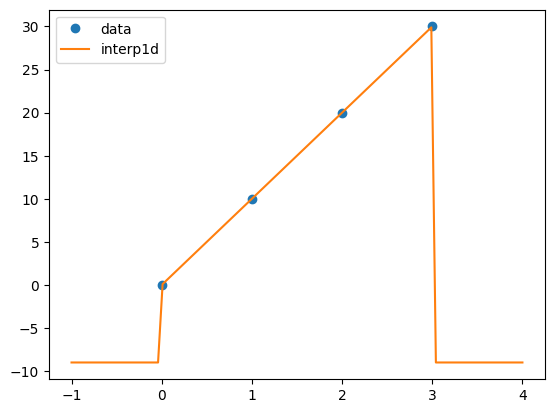

In [ ]:
import jax
import jax.numpy as jnp

def interp1d(grid, data, query, fill_value=0.0):
    """
    Simple 1D jax linear interpolation for regularly sampled data.

    Parameters
    ----------
    grid : jnp.ndarray
        Grid points, shape (num_pts,). Must be increasing and regularly spaced.
    data : jnp.ndarray
        Values to be interpolated, shape (num_pts,).
    query : jnp.ndarray
        Query locations, shape (num_queries,).
    fill_value : float, optional
        Value used when query is outside grid range.

    Returns
    -------
    y : jnp.ndarray
        Interpolated values at query points, shape (num_queries,).
    """
    grid = jnp.asarray(grid)
    data = jnp.asarray(data)
    query = jnp.asarray(query)

    num_pts = grid.shape[0]
    assert data.shape[0] == num_pts, "data must have same shape as grid"

    grid_spacing = grid[1] - grid[0]
    assert jnp.allclose(jnp.diff(grid), grid_spacing), "grid must be regularly spaced."

    # find index of the left cell boundary for each x
    i = jnp.searchsorted(grid, query, side="right") - 1
    i = jnp.clip(i, 0, num_pts - 2)  

    # linear weights
    x0 = grid[i]
    x1 = grid[i + 1]
    v0 = data[i]
    v1 = data[i + 1]
    t = (query - x0) / grid_spacing
    y = v0 + t * (v1 - v0)

    # handle out-of-bounds
    in_bounds = (query >= grid[0]) & (query <= grid[-1])
    y = jnp.where(in_bounds, y, fill_value)

    return y

grid = jnp.array([0.0, 1.0, 2.0, 3.0])
data = jnp.array([0.0, 10.0, 20.0, 30.0])
query = jnp.linspace(-1.0, 4.0, 100)
I = interp1d(grid, data, query, fill_value=-9.0)
plt.plot(grid, data, 'o', label='data')
plt.plot(query, I, '-', label='interp1d')
plt.legend()
plt.show()

In [ ]:
def interp2d(x_grid, y_grid, data, query, fill_value=0.0):
    """
    Simple 2D jax linear interpolation for regularly sampled data.

    Parameters
    ----------
    x_grid : jnp.ndarray
        Grid points, shape (num_x_pts,). Must be increasing and regularly spaced.
    y_grid : jnp.ndarray
        Grid points, shape (num_y_pts,). Must be increasing and regularly spaced.
    data : jnp.ndarray
        Values to be interpolated, shape (num_x_pts, num_y_pts).
    query : jnp.ndarray
        Query locations, shape (num_queries, 2).
    fill_value : float, optional
        Value used when query is outside grid range.

    Returns
    -------
    y : jnp.ndarray
        Interpolated values at query points, shape (num_queries,).
    """
    x_grid = jnp.asarray(x_grid)
    y_grid = jnp.asarray(y_grid)
    data = jnp.asarray(data)
    query = jnp.asarray(query)

    num_x_pts = x_grid.shape[0]
    num_y_pts = y_grid.shape[0]
    assert data.shape == (num_x_pts, num_y_pts), "data must have same shape as grid"

    grid_x_spacing = x_grid[1] - x_grid[0]
    grid_y_spacing = y_grid[1] - y_grid[0]
    assert jnp.allclose(jnp.diff(x_grid), grid_x_spacing), "x_grid must be regularly spaced."
    assert jnp.allclose(jnp.diff(y_grid), grid_y_spacing), "y_grid must be regularly spaced."

    x = query[:, 0]
    y = query[:, 1]

    # Find grid cell indices for each query
    ix = jnp.searchsorted(x_grid, x, side="right") - 1
    iy = jnp.searchsorted(y_grid, y, side="right") - 1
    ix = jnp.clip(ix, 0, len(x_grid) - 2)
    iy = jnp.clip(iy, 0, len(y_grid) - 2)

    # Compute fractional positions within cell
    x0, x1 = x_grid[ix], x_grid[ix + 1]
    y0, y1 = y_grid[iy], y_grid[iy + 1]
    tx = (x - x0) / grid_x_spacing
    ty = (y - y0) / grid_y_spacing

    # Gather corner values
    f00 = data[ix, iy]
    f10 = data[ix + 1, iy]
    f01 = data[ix, iy + 1]
    f11 = data[ix + 1, iy + 1]

    # Bilinear interpolation
    interp = (
        (1 - tx) * (1 - ty) * f00 +
        tx * (1 - ty) * f10 +
        (1 - tx) * ty * f01 +
        tx * ty * f11
    )

    # Mask out-of-bounds queries
    in_bounds = (
        (x >= x_grid[0]) & (x <= x_grid[-1]) &
        (y >= y_grid[0]) & (y <= y_grid[-1])
    )
    interp = jnp.where(in_bounds, interp, fill_value)
    return interp

x_grid = jnp.array([0.0, 1.0, 2.0, 3.0])
y_grid = jnp.array([0.0, 1.0, 2.0])
data = jnp.zeros((4,3))
query = jnp.array([[-0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6]])
I = interp2d(x_grid, y_grid, data, query, fill_value=-9.0)
I.shape

[0 0 0 0 0]


(5,)

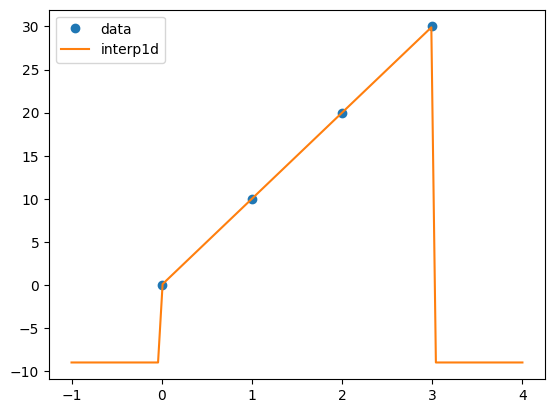

In [88]:
def interp_ndim(grids, data, query, fill_value=0.0):
    """
    Simple D-dimensional jax linear interpolation for regularly sampled data.

    Parameters
    ----------
    grids : tuple, length dim
        E.g. (grid_0, grid_1, ...) where grids_d is a 1D increasing and 
        regularly spaced jax array of shape (num_pts_d,) for dimension d.
    data : jnp.ndarray
        Values to be interpolated, shape (num_pts_0, num_pts_1, ...).
    query : jnp.ndarray
        Query locations, shape (num_queries, dim).
    fill_value : float, optional
        Value used when query is outside grid range.

    Returns
    -------
    y : jnp.ndarray
        Interpolated values at query points, shape (num_queries,).
    """
    data = jnp.asarray(data)
    query = jnp.asarray(query)

    dim = len(grids)

    grid_shape = tuple(g.shape[0] for g in grids)
    assert data.shape == grid_shape, "data must have same shape as grid"

    grid_spacing = tuple(g[1] - g[0] for g in grids)
    for d in range(len(grids)):
        assert jnp.allclose(jnp.diff(grids[d]), grid_spacing[d]), "grid is not regularly spaced along dimension {}.".format(d)

    assert query[0,...].shape == (dim,), "query dimension does not match grids."

    # Per-axis: cell index (left), fractional weight t, and in-bounds check for each query
    idx_list = []
    t_list = []
    inb_list = []
    for d in range(dim):
        grid_d = grids[d]
        x_d = query[:, d]

        i = jnp.searchsorted(grid_d, x_d, side="right") - 1
        i = jnp.clip(i, 0, grid_shape[d] - 2)
        x0 = grid_d[i]
        td = (x_d - x0) / grid_spacing[d]

        idx_list.append(i)
        t_list.append(td)
        inb_list.append((x_d >= grid_d[0]) & (x_d <= grid_d[-1]))

    idx = jnp.stack(idx_list, axis=0)      # (dim, num_queries)
    t   = jnp.stack(t_list,   axis=0)      # (dim, num_queries)
    in_bounds = jnp.logical_and.reduce(jnp.stack(inb_list, axis=0), axis=0)  # (num_queries,)

    # Enumerate all 2^D corners without loops, via broadcasting
    corners = jnp.stack(jnp.indices((2,) * dim), axis=-1).reshape(-1, dim)   # (C, dim)
    C = corners.shape[0]

    # Corner indices per query: (C, dim, num_queries)
    corner_idx = idx[None, :, :] + corners[:, :, None]

    # Corner weights per query: (C, num_queries)
    factors = jnp.where(corners[:, :, None] == 1, t[None, :, :], 1.0 - t[None, :, :])
    w = jnp.prod(factors, axis=1)  # (C, num_queries)

    # Flatten grid dims so we can gather by raveled indices
    P = int(jnp.prod(jnp.array(grid_shape)))
    values_flat = data.reshape(P)   # (P,)

    # Ravel corner multi-indices to 1D indices: (C, num_queries)
    p = jnp.ravel_multi_index(corner_idx.transpose(1, 0, 2), dims=grid_shape)

    # Gather and weight: values_flat[p[c,q]] → (C, num_queries)
    corner_vals = values_flat[p]
    y = jnp.sum(w * corner_vals, axis=0)  # (num_queries,)

    # deal with out-of-bounds queries
    y = jnp.where(in_bounds, y, fill_value)

    return y

grid = jnp.array([0.0, 1.0, 2.0, 3.0])
data = jnp.array([0.0, 10.0, 20.0, 30.0])
query = jnp.atleast_2d(jnp.linspace(-1.0, 4.0, 100)).T
I = interp_ndim((grid,), data, query, fill_value=-9.0)
plt.plot(grid, data, 'o', label='data')
plt.plot(query, I, '-', label='interp1d')
plt.legend()
plt.show()

In [102]:
def linear_interp_coeff_data_ndim(grids, data, query, fill_value=0.0):
    """
    D-dimensional interpolation of the cnm, snm coefficient matrix-valued data. 
    Simple, jax-compatible, D-dimensional linear interpolation that works with 
    data that is regularly sampled along each axis. The interpolation is 
    queried at a different point for each row (n-axis) of the data.

    Parameters
    ----------
    grids : tuple, length dim
        E.g. (grid_0, grid_1, ...) where grids_d is a 1D increasing and 
        regularly spaced jax array of shape (num_pts_d,) for dimension d.
    data : jnp.ndarray
        Values to be interpolated, shape (num_pts_0, num_pts_1, ..., N, M).
    query : jnp.ndarray
        Query locations, shape (dim, N).
    fill_value : float, optional
        Value used when query is outside grid range.

    Returns
    -------
    y : jnp.ndarray
        Interpolated values at query points, shape (num_queries,).
    """
    dim = len(grids)
    grid_shape = tuple(g.shape[0] for g in grids)

    data = jnp.asarray(data)
    N, M = data.shape[-2], data.shape[-1]
    assert data[...,0,0].shape == grid_shape, \
            "data must match shape of grids"

    grid_spacing = tuple(g[1] - g[0] for g in grids)
    for g, grid in enumerate(grids):
        assert jnp.allclose(jnp.diff(grid), grid_spacing[g]), \
            "grid is not regularly spaced along dimension {}.".format(g)

    query = jnp.asarray(query)
    assert query.shape == (dim, N), \
            "query dimension {} does not match ({}, {}).".format(query.shape, dim, N)

    # ----- per-axis: left cell indices and fractional weights t in [0,1] -----
    # Using arithmetic (regular grid): u = (x - g0)/dx, i = floor(u), t = frac(u)
    idx_list = []
    t_list = []
    inb_list = []

    for d in range(dim):
        g = grids[d]                                 # (Sd,)
        Sd = g.shape[0]
        g0 = g[0]
        dx = g[1] - g[0]                             # regular spacing
        # (D, N) -> (N,) for this axis
        qd = query[d, :]                             # (N,)

        # continuous coordinate in grid units
        u = (qd - g0) / grid_spacing[d]             # (N,)
        i = jnp.floor(u).astype(jnp.int32)          # left index
        # clamp to interior so i+1 is valid
        i = jnp.clip(i, 0, grid_shape[d] - 2)
        t = u - i                                    # fractional part in [0,1) ideally

        idx_list.append(i)                           # (N,)
        t_list.append(t)                             # (N,)
        inb_list.append((qd >= g0) & (qd <= g[-1]))  # (N,)

    idx = jnp.stack(idx_list, axis=0)                # (D, N)
    t   = jnp.stack(t_list,   axis=0)                # (D, N)
    in_bounds = jnp.logical_and.reduce(jnp.stack(inb_list, axis=0), axis=0)  # (N,)

    # ----- enumerate 2^D corners (no Python loop over corners) -----
    corners = jnp.stack(jnp.indices((2,) * dim), axis=-1).reshape(-1, dim)  # (C, dim)
    C = corners.shape[0]

    # Corner indices for each n: (C, dim, N)
    corner_idx = idx[None, :, :] + corners[:, :, None]

    # Corner weights for each n: (C, N)
    factors = jnp.where(corners[:, :, None] == 1, t[None, :, :], 1.0 - t[None, :, :])
    w = jnp.prod(factors, axis=1)  # (C, N)

    # ----- gather all corner matrices at once -----
    P = int(jnp.prod(jnp.array(grid_shape)))
    values_flat = data.reshape(P, N, M)                                   # (P, N, M)

    # ravel (C, D, N) -> (C, N) linear indices into first D dims
    p = jnp.ravel_multi_index(corner_idx.transpose(1, 0, 2),
                              dims=grid_shape)                       # (C, N)

    # Gather corner matrices for each (c, n): (C, N, M)
    corner_vals = values_flat[p, jnp.arange(N)[None, :], :]               # (C, N, M)

    # Weighted sum over corners -> (N, M)
    y = jnp.sum(w[:, :, None] * corner_vals, axis=0)                    # (N, M)

    # ----- out-of-bounds fill (row-wise) -----
    y = jnp.where(in_bounds[:, None], y, fill_value)

    return y


f_grid = jnp.linspace(0, 1, 10)

grids = (f_grid, )

data = [ [[f,f],[f,f]] for f in f_grid ]
data = jnp.array(data)

query = jnp.array([[0.2,0.4]])

linear_interp_coeff_data_ndim(grids, data, query)

Array([[0.20000002, 0.20000002],
       [0.40000004, 0.40000004]], dtype=float32)